<a href="https://colab.research.google.com/github/JhoelHairton/Aplicativo-Demo/blob/main/AN%C3%81LISIS_DE_CLUSTERING_PORTAL_DE_NOTICIAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ANÁLISIS DE CLUSTERING - PORTAL DE NOTICIAS


In [1]:
!pip install pandas numpy scikit-learn matplotlib seaborn wordcloud

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

# Configuración de estilo
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# 1. CARGA Y PREPARACIÓN DE DATOS


In [3]:
print("="*70)
print("ANÁLISIS DE CLUSTERING - PORTAL DE NOTICIAS")
print("="*70)

# Cargar datos
df = pd.read_csv('news_data.csv', sep=';')
print(f"\n Total de noticias: {len(df)}")
print(f" Fuentes: {df['source'].unique()}")
print(f" Rango de fechas: {df['published'].min()} a {df['published'].max()}")

# Preparar texto para análisis
df['texto_completo'] = df['title'] + ' ' + df['summary']
df['published'] = pd.to_datetime(df['published'])
df['year'] = df['published'].dt.year
df['month'] = df['published'].dt.month

print("\n Datos preparados exitosamente")

ANÁLISIS DE CLUSTERING - PORTAL DE NOTICIAS

 Total de noticias: 1000
 Fuentes: ['BBC Mundo' 'El Comercio' 'RPP']
 Rango de fechas: 2023-01-01 03:18:33 a 2025-11-01 23:46:39

 Datos preparados exitosamente


# 2. VECTORIZACIÓN DEL TEXTO (TF-IDF)


In [5]:
print("\n" + "="*70)
print("VECTORIZACIÓN DE TEXTO CON TF-IDF")
print("="*70)

vectorizer = TfidfVectorizer(
    max_features=500,
    max_df=0.8,
    min_df=2,
    ngram_range=(1, 2),
    stop_words=None
)

X_tfidf = vectorizer.fit_transform(df['texto_completo'])
print(f"\n Matriz TF-IDF: {X_tfidf.shape}")
print(f"Características extraídas: {len(vectorizer.get_feature_names_out())}")


VECTORIZACIÓN DE TEXTO CON TF-IDF

 Matriz TF-IDF: (1000, 474)
Características extraídas: 474


# 3. MÉTODO DEL CODO (Elbow Method)



DETERMINACIÓN DEL NÚMERO ÓPTIMO DE CLUSTERS


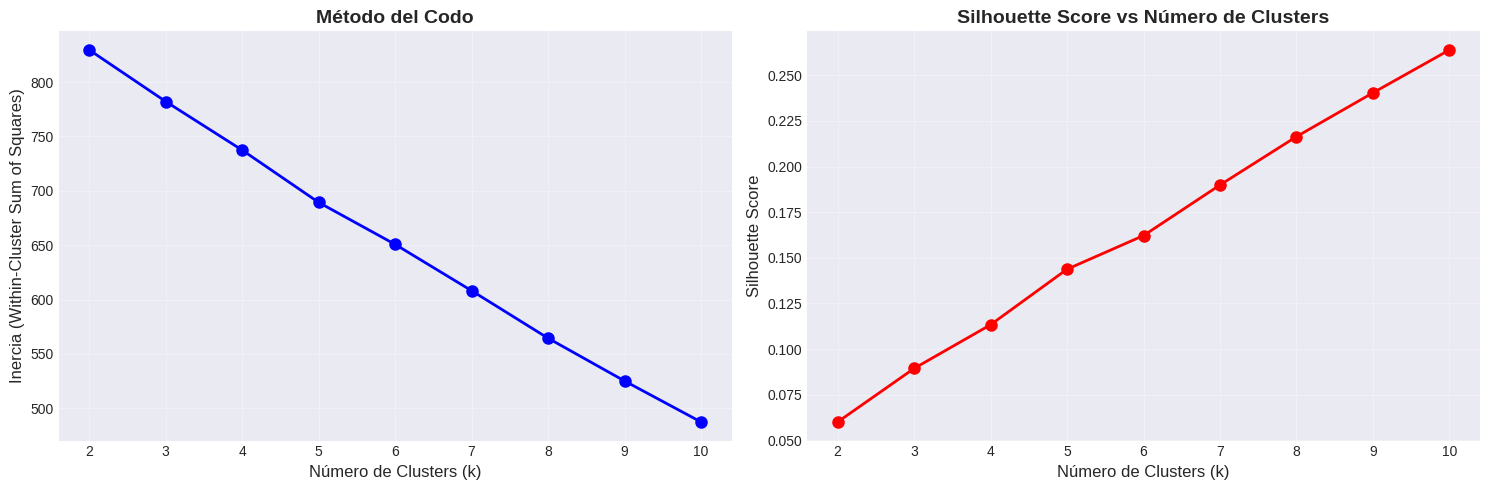


🎯 Número óptimo de clusters (por Silhouette): 10


In [7]:
print("\n" + "="*70)
print("DETERMINACIÓN DEL NÚMERO ÓPTIMO DE CLUSTERS")
print("="*70)

inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_tfidf)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_tfidf, kmeans.labels_))

# Visualización del Método del Codo
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Gráfico 1: Inercia
axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Número de Clusters (k)', fontsize=12)
axes[0].set_ylabel('Inercia (Within-Cluster Sum of Squares)', fontsize=12)
axes[0].set_title('Método del Codo', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Gráfico 2: Silhouette Score
axes[1].plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Número de Clusters (k)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Score vs Número de Clusters', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Determinar k óptimo
k_optimo = K_range[np.argmax(silhouette_scores)]
print(f"\n🎯 Número óptimo de clusters (por Silhouette): {k_optimo}")

# 4. APLICACIÓN DE K-MEANS


In [8]:
print("\n" + "="*70)
print(f"APLICACIÓN DE K-MEANS CON K={k_optimo}")
print("="*70)

kmeans = KMeans(n_clusters=k_optimo, random_state=42, n_init=10)
df['cluster_kmeans'] = kmeans.fit_predict(X_tfidf)

# Métricas de evaluación
silhouette = silhouette_score(X_tfidf, df['cluster_kmeans'])
davies_bouldin = davies_bouldin_score(X_tfidf.toarray(), df['cluster_kmeans'])
calinski = calinski_harabasz_score(X_tfidf.toarray(), df['cluster_kmeans'])

print(f"\n📊 MÉTRICAS DE EVALUACIÓN:")
print(f"   • Silhouette Score: {silhouette:.4f} (Mejor: cercano a 1)")
print(f"   • Davies-Bouldin Index: {davies_bouldin:.4f} (Mejor: cercano a 0)")
print(f"   • Calinski-Harabasz Index: {calinski:.2f} (Mejor: valores altos)")

# Distribución de clusters
print(f"\n📈 DISTRIBUCIÓN DE NOTICIAS POR CLUSTER:")
for i in range(k_optimo):
    count = (df['cluster_kmeans'] == i).sum()
    percentage = (count / len(df)) * 100
    print(f"   Cluster {i}: {count} noticias ({percentage:.1f}%)")


APLICACIÓN DE K-MEANS CON K=10

📊 MÉTRICAS DE EVALUACIÓN:
   • Silhouette Score: 0.2639 (Mejor: cercano a 1)
   • Davies-Bouldin Index: 1.5920 (Mejor: cercano a 0)
   • Calinski-Harabasz Index: 88.16 (Mejor: valores altos)

📈 DISTRIBUCIÓN DE NOTICIAS POR CLUSTER:
   Cluster 0: 96 noticias (9.6%)
   Cluster 1: 112 noticias (11.2%)
   Cluster 2: 102 noticias (10.2%)
   Cluster 3: 91 noticias (9.1%)
   Cluster 4: 107 noticias (10.7%)
   Cluster 5: 107 noticias (10.7%)
   Cluster 6: 90 noticias (9.0%)
   Cluster 7: 99 noticias (9.9%)
   Cluster 8: 105 noticias (10.5%)
   Cluster 9: 91 noticias (9.1%)


# 5. VISUALIZACIÓN CON PCA (2D)



VISUALIZACIÓN DE CLUSTERS CON PCA


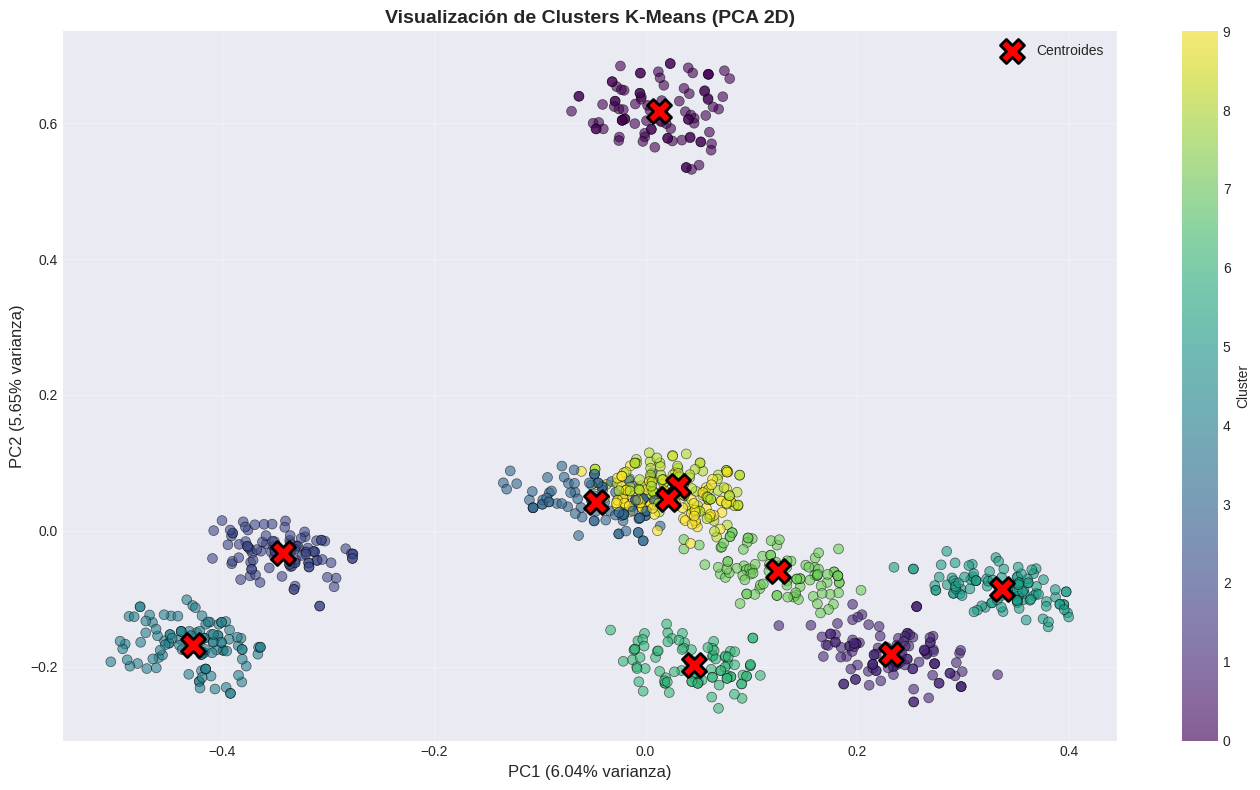


✅ Varianza explicada total: 11.69%


In [9]:
print("\n" + "="*70)
print("VISUALIZACIÓN DE CLUSTERS CON PCA")
print("="*70)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_tfidf.toarray())

plt.figure(figsize=(14, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1],
                     c=df['cluster_kmeans'],
                     cmap='viridis',
                     s=50,
                     alpha=0.6,
                     edgecolors='black',
                     linewidth=0.5)
plt.colorbar(scatter, label='Cluster')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} varianza)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} varianza)', fontsize=12)
plt.title('Visualización de Clusters K-Means (PCA 2D)', fontsize=14, fontweight='bold')

# Agregar centroides
centroids_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1],
           c='red', marker='X', s=300,
           edgecolors='black', linewidth=2,
           label='Centroides')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n✅ Varianza explicada total: {sum(pca.explained_variance_ratio_):.2%}")

# 6. ANÁLISIS DE CONTENIDO POR CLUSTER



ANÁLISIS DE TÉRMINOS MÁS RELEVANTES POR CLUSTER

🔹 CLUSTER 0:
   Top términos: gobierno anuncia, gobierno, nuevo, nuevo plan, anuncia nuevo

🔹 CLUSTER 1:
   Top términos: ciudadanos, ciudadanos reclaman, reclaman, reclaman medidas, medidas sobre

🔹 CLUSTER 2:
   Top términos: la región, revela impacto, impacto de, revela, investigación revela

🔹 CLUSTER 3:
   Top términos: regular, de ley, proyecto, proyecto de, ley busca

🔹 CLUSTER 4:
   Top términos: el trimestre, en el, economía muestra, signos, signos de

🔹 CLUSTER 5:
   Top términos: crisis, crisis por, obliga autoridades, obliga, tomar

🔹 CLUSTER 6:
   Top términos: pública sobre, muestra opinión, opinión, opinión pública, encuesta

🔹 CLUSTER 7:
   Top términos: sus efectos, sus, debaten sobre, debaten, efectos

🔹 CLUSTER 8:
   Top términos: crecimiento, supera, crecimiento del, supera expectativas, expectativas

🔹 CLUSTER 9:
   Top términos: tecnología, tecnología avanza, presentada, avanza, avanza nueva


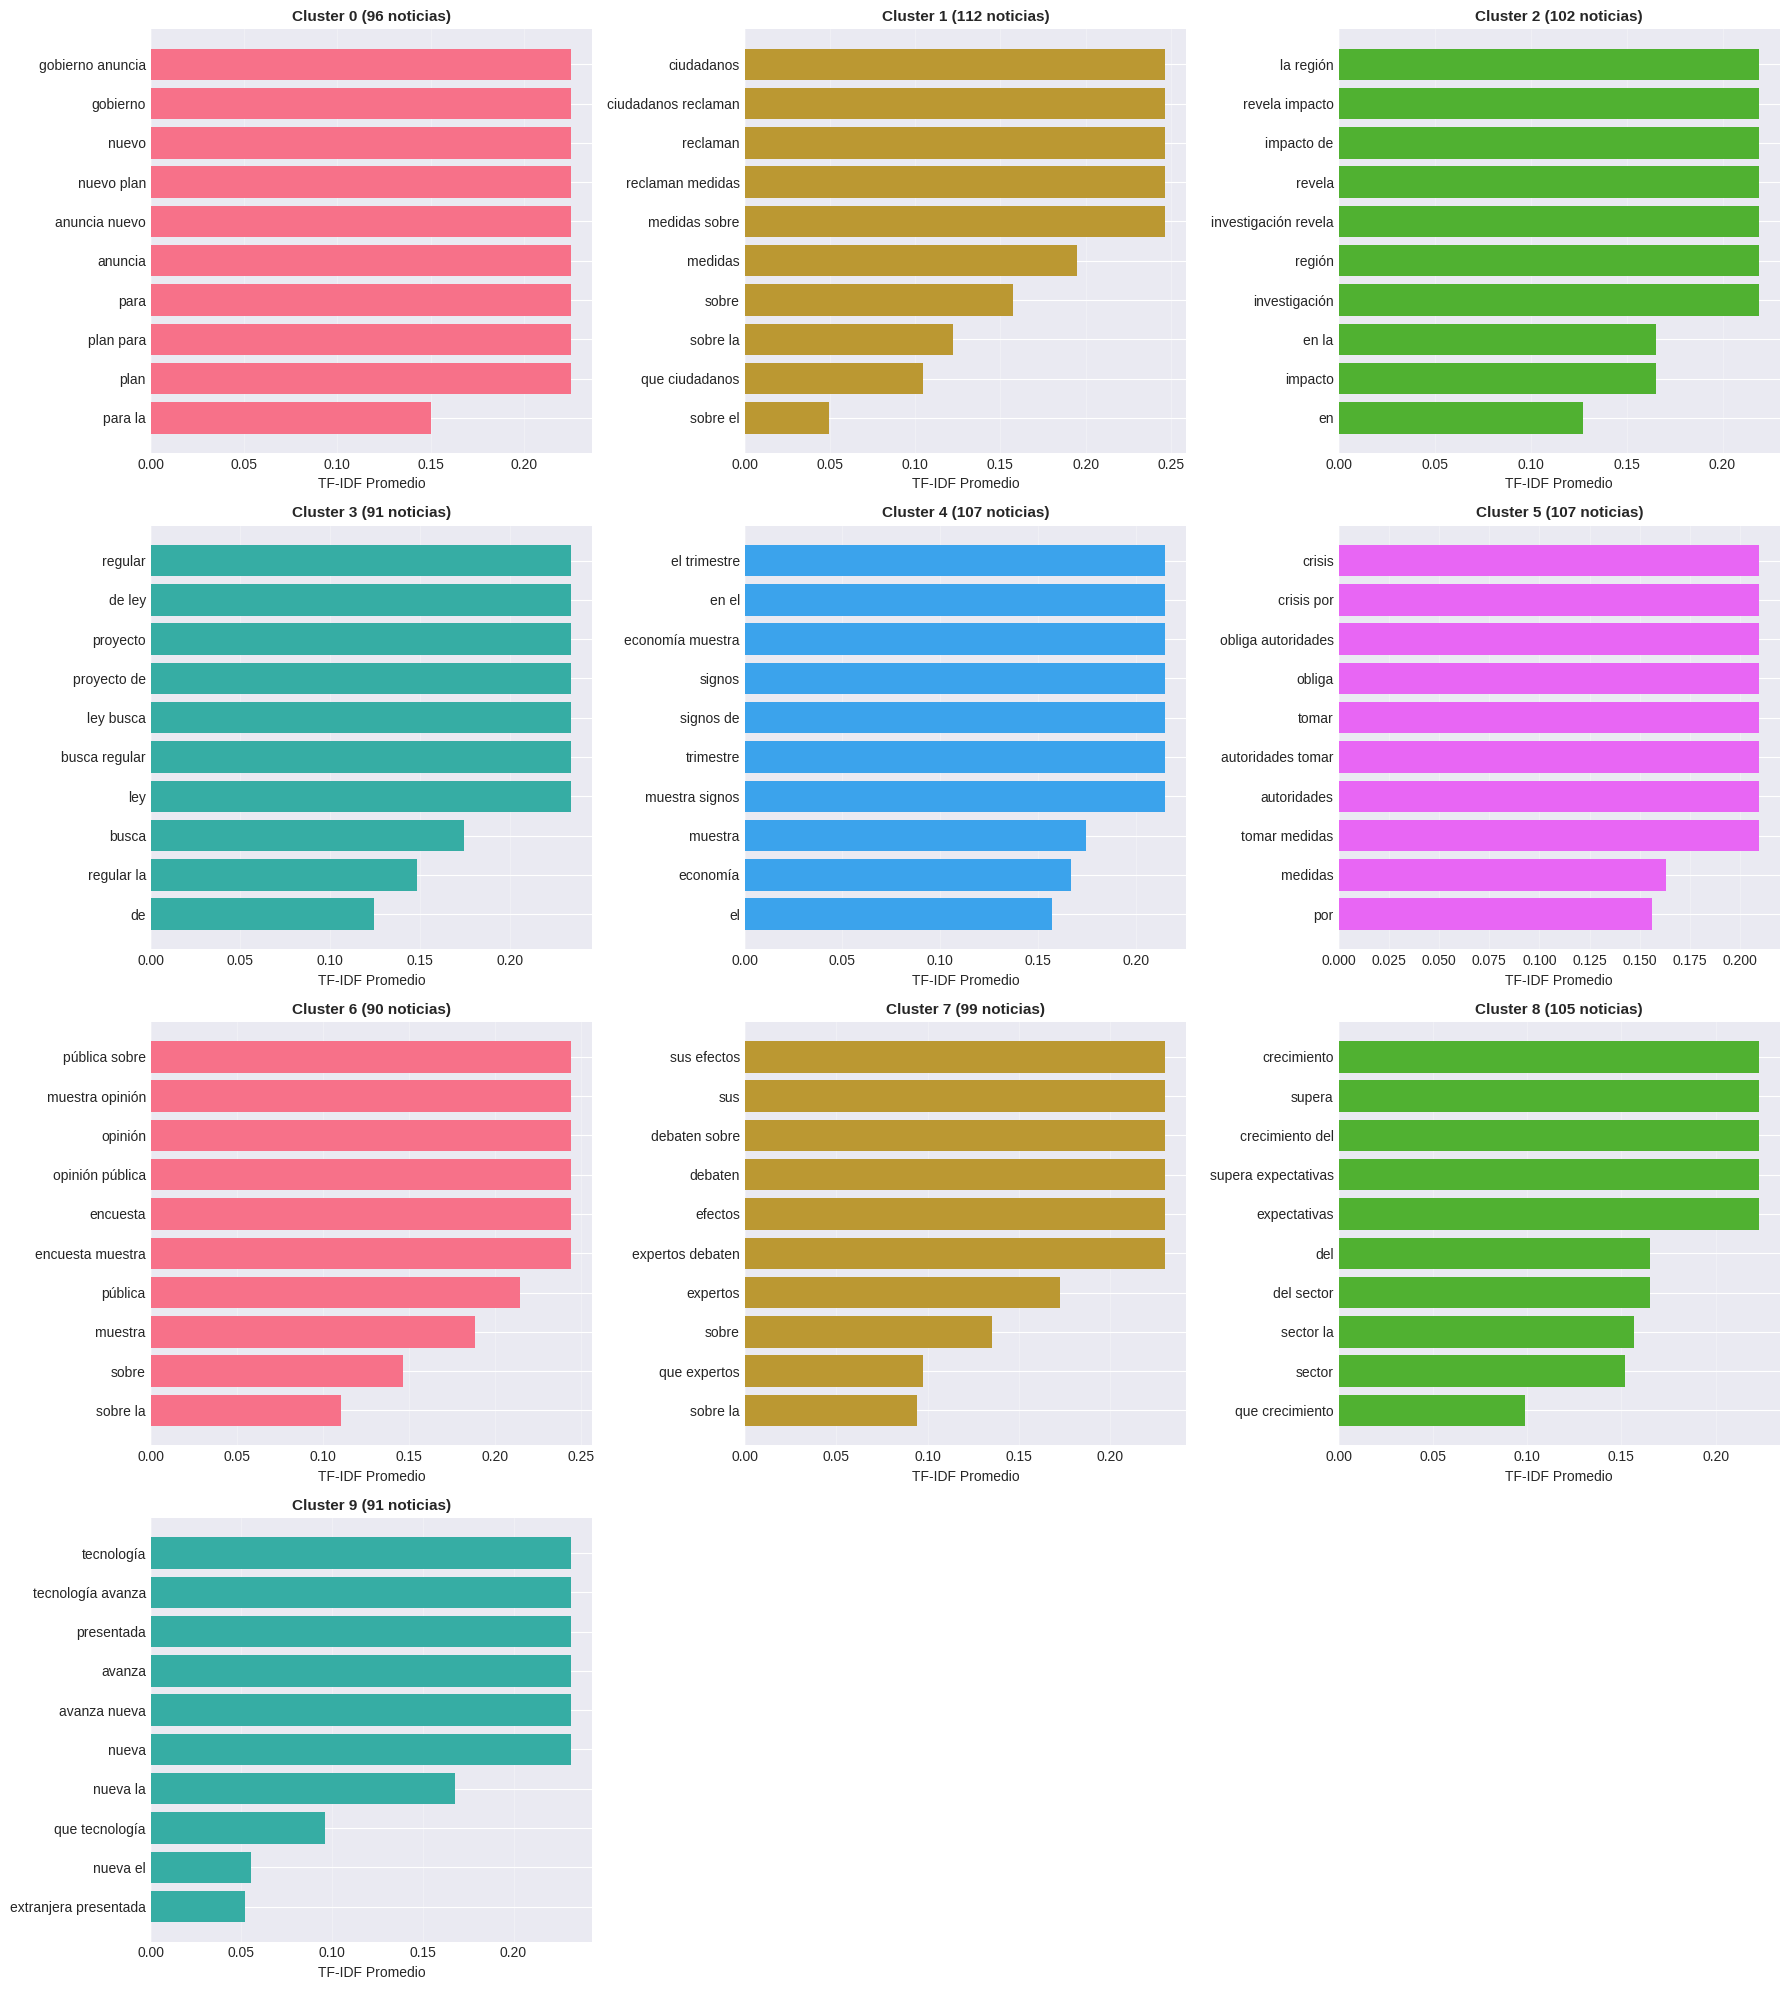

In [11]:
print("\n" + "="*70)
print("ANÁLISIS DE TÉRMINOS MÁS RELEVANTES POR CLUSTER")
print("="*70)

feature_names = vectorizer.get_feature_names_out()

# Calculate number of rows and columns for subplots
n_cols = 3  # You can adjust the number of columns as needed
n_rows = (k_optimo + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 5))
axes = axes.ravel()

for i in range(k_optimo):
    # Obtener índices de documentos en el cluster
    cluster_docs = df[df['cluster_kmeans'] == i].index

    # Calcular importancia promedio de términos en el cluster
    cluster_tfidf = X_tfidf[cluster_docs].toarray().mean(axis=0)
    top_indices = cluster_tfidf.argsort()[-10:][::-1]
    top_terms = [feature_names[idx] for idx in top_indices]
    top_scores = [cluster_tfidf[idx] for idx in top_indices]

    # Visualizar
    axes[i].barh(range(len(top_terms)), top_scores, color=f'C{i}')
    axes[i].set_yticks(range(len(top_terms)))
    axes[i].set_yticklabels(top_terms)
    axes[i].invert_yaxis()
    axes[i].set_xlabel('TF-IDF Promedio', fontsize=10)
    axes[i].set_title(f'Cluster {i} ({(df["cluster_kmeans"]==i).sum()} noticias)',
                     fontweight='bold', fontsize=11)
    axes[i].grid(axis='x', alpha=0.3)

    print(f"\n🔹 CLUSTER {i}:")
    print(f"   Top términos: {', '.join(top_terms[:5])}")

# Ocultar ejes sobrantes
for j in range(k_optimo, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# 7. NUBE DE PALABRAS POR CLUSTER



GENERACIÓN DE NUBES DE PALABRAS


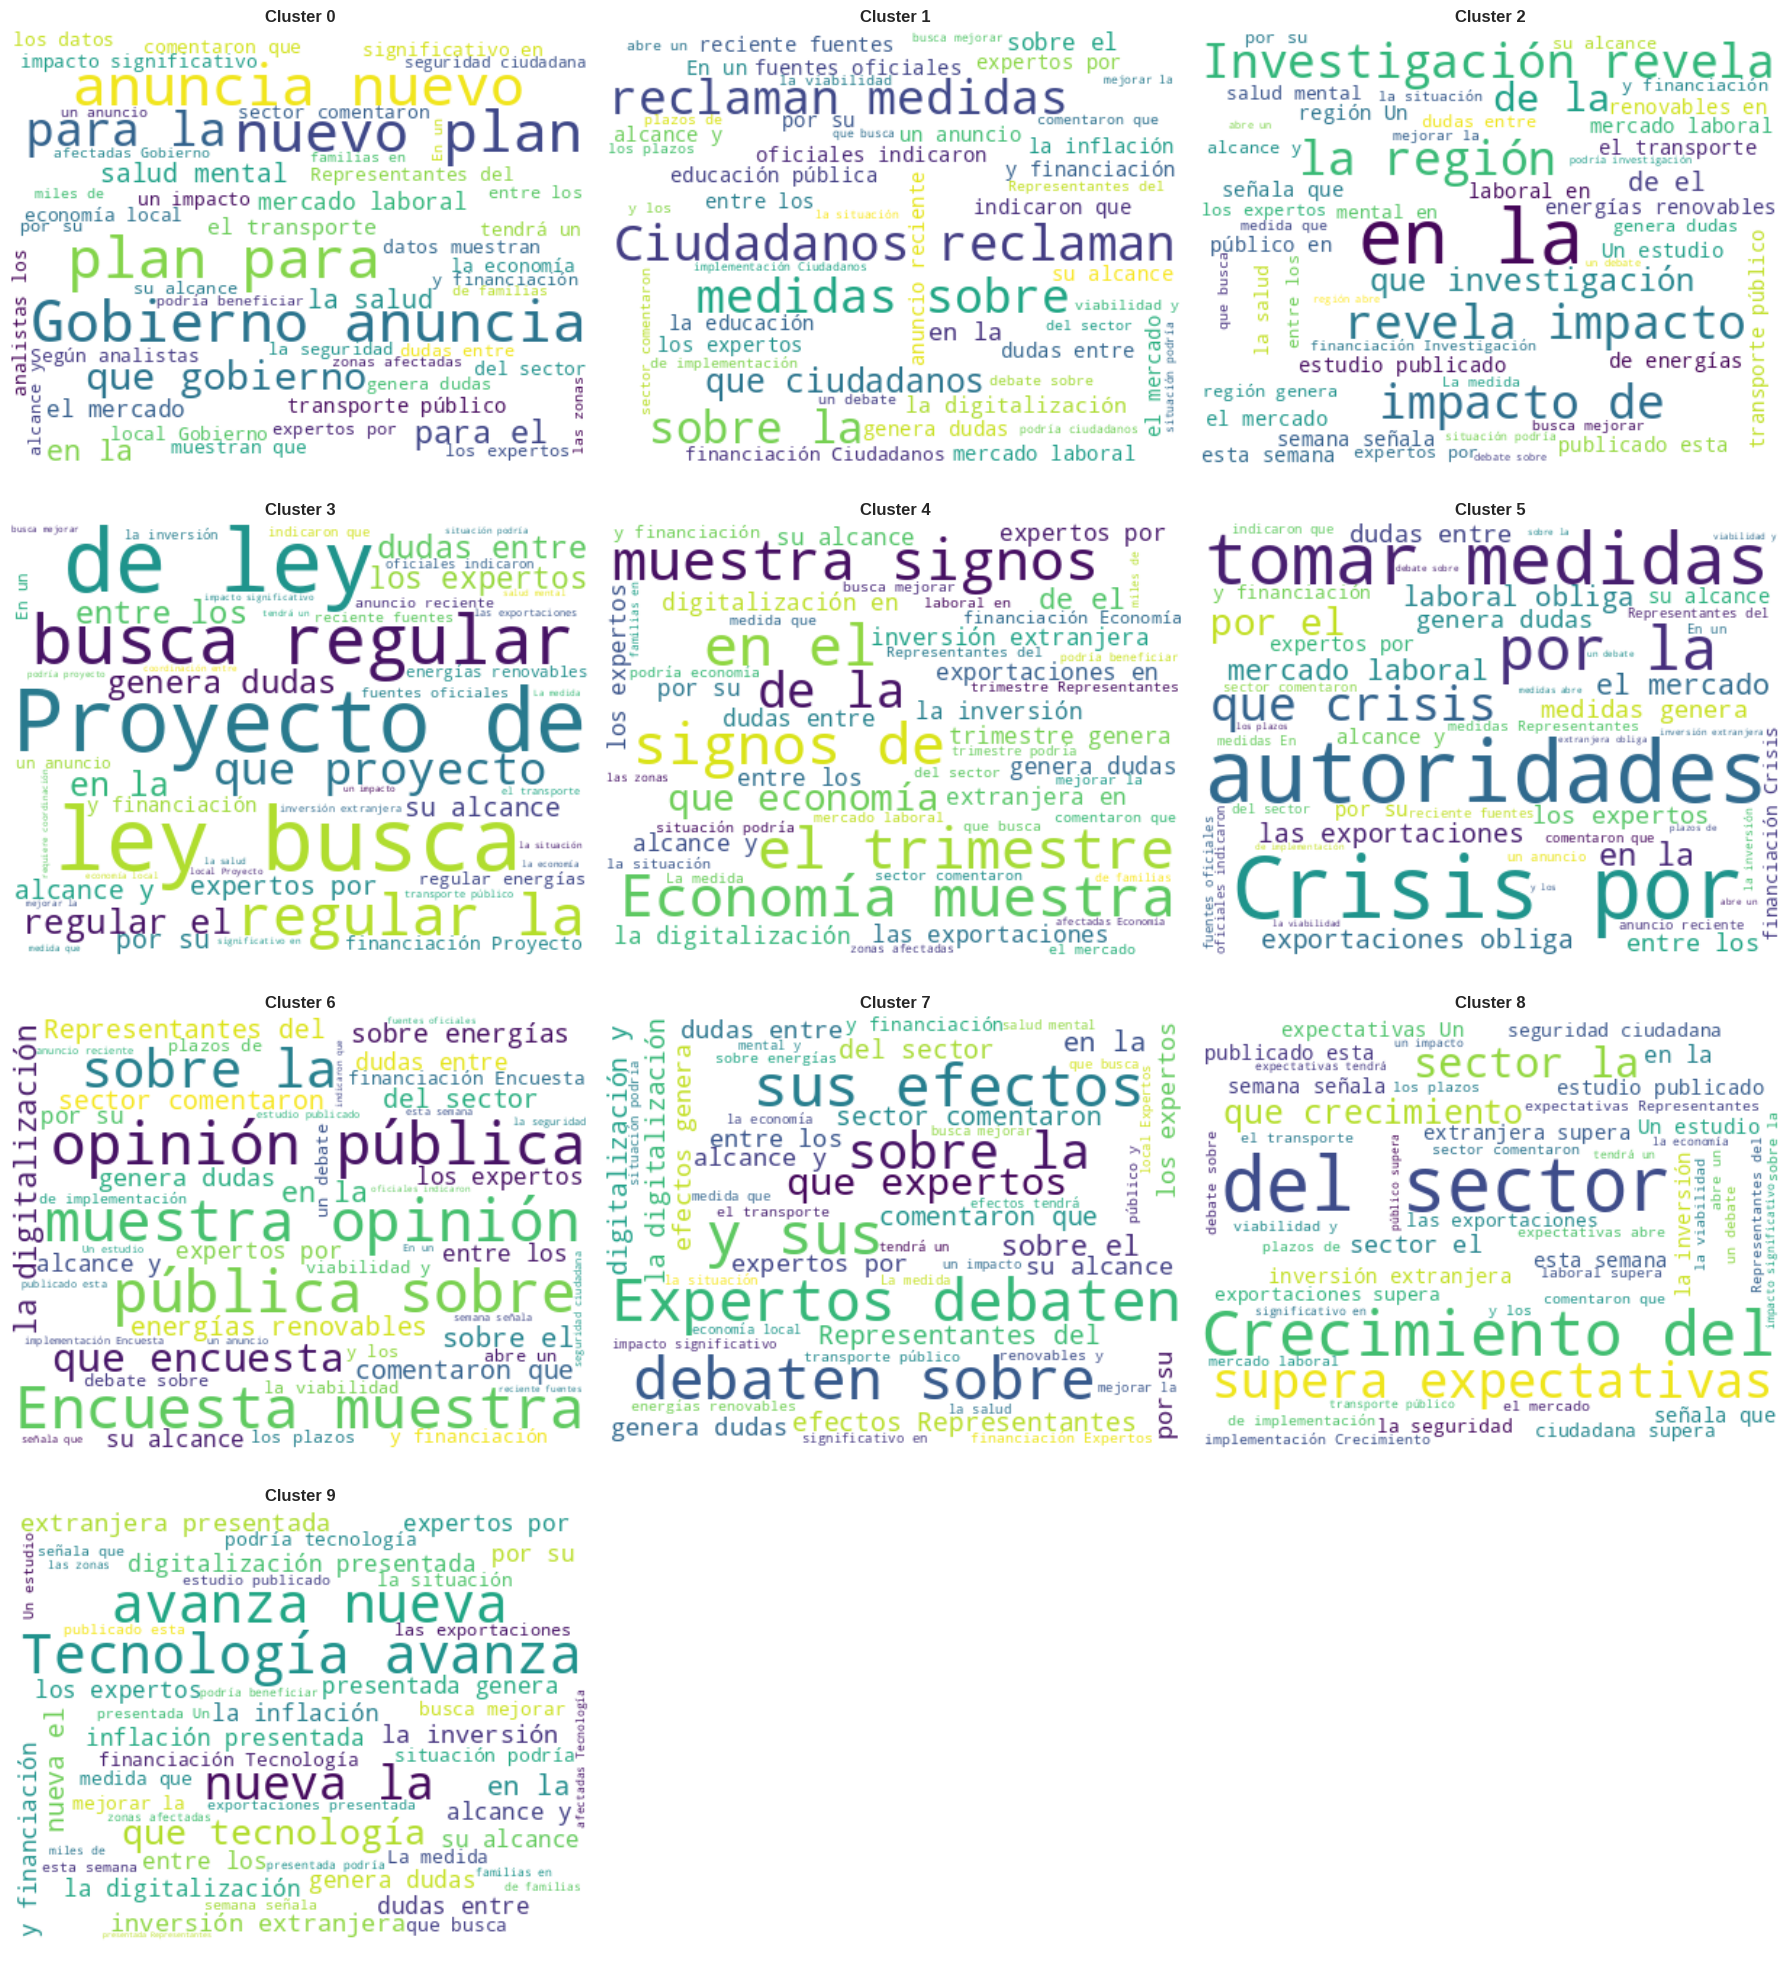

In [13]:
print("\n" + "="*70)
print("GENERACIÓN DE NUBES DE PALABRAS")
print("="*70)


# Calculate number of rows and columns for subplots
n_cols = 3  # You can adjust the number of columns as needed
n_rows = (k_optimo + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 5))
axes = axes.ravel()

for i in range(k_optimo):
    cluster_texts = ' '.join(df[df['cluster_kmeans'] == i]['texto_completo'].values)

    wordcloud = WordCloud(
        width=400,
        height=300,
        background_color='white',
        colormap='viridis',
        max_words=50
    ).generate(cluster_texts)

    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(f'Cluster {i}', fontsize=12, fontweight='bold')

for j in range(k_optimo, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# 8. DISTRIBUCIÓN POR FUENTE Y TIEMPO



ANÁLISIS DE DISTRIBUCIÓN POR FUENTE Y TIEMPO


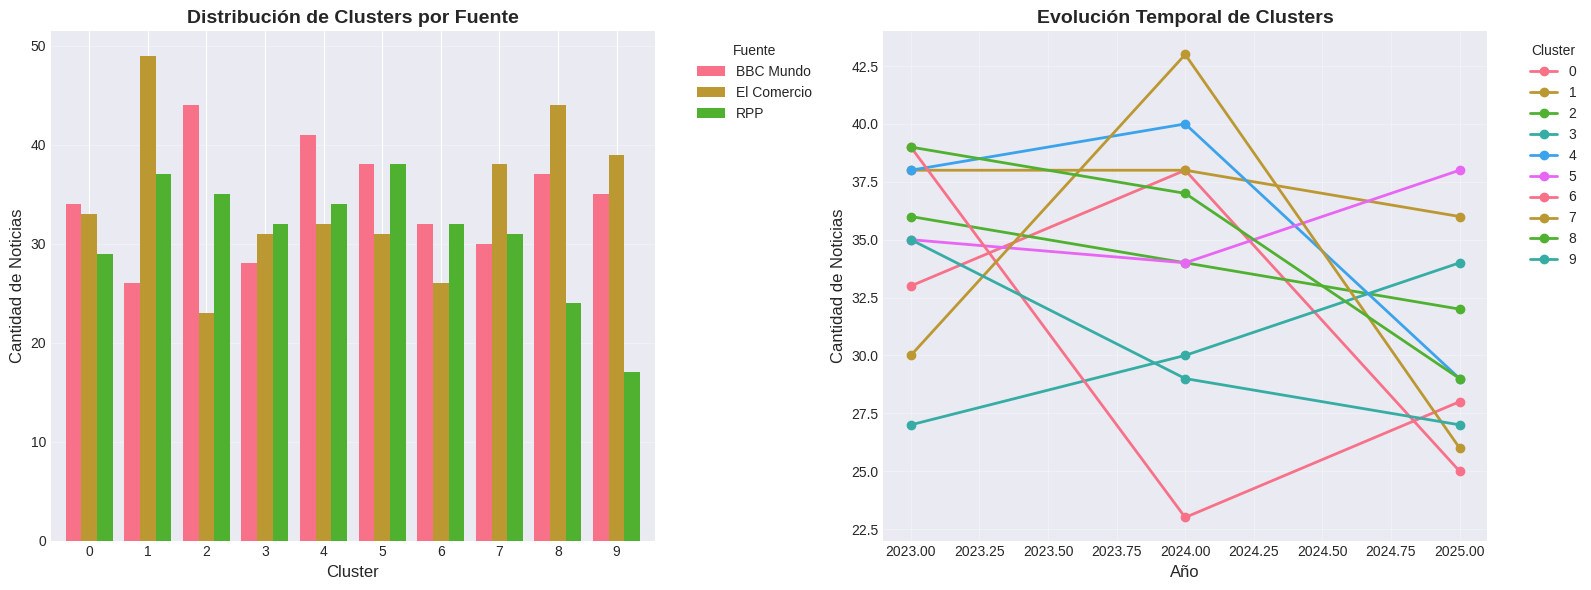

In [14]:
print("\n" + "="*70)
print("ANÁLISIS DE DISTRIBUCIÓN POR FUENTE Y TIEMPO")
print("="*70)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Distribución por fuente
cluster_source = pd.crosstab(df['cluster_kmeans'], df['source'])
cluster_source.plot(kind='bar', ax=axes[0], width=0.8)
axes[0].set_xlabel('Cluster', fontsize=12)
axes[0].set_ylabel('Cantidad de Noticias', fontsize=12)
axes[0].set_title('Distribución de Clusters por Fuente', fontsize=14, fontweight='bold')
axes[0].legend(title='Fuente', bbox_to_anchor=(1.05, 1))
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# Distribución temporal
cluster_year = pd.crosstab(df['cluster_kmeans'], df['year'])
cluster_year.T.plot(kind='line', ax=axes[1], marker='o', linewidth=2)
axes[1].set_xlabel('Año', fontsize=12)
axes[1].set_ylabel('Cantidad de Noticias', fontsize=12)
axes[1].set_title('Evolución Temporal de Clusters', fontsize=14, fontweight='bold')
axes[1].legend(title='Cluster', bbox_to_anchor=(1.05, 1))
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 9. COMPARACIÓN DE ALGORITMOS


In [15]:
print("\n" + "="*70)
print("COMPARACIÓN CON OTROS ALGORITMOS DE CLUSTERING")
print("="*70)

# DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
df['cluster_dbscan'] = dbscan.fit_predict(X_tfidf)
n_clusters_dbscan = len(set(df['cluster_dbscan'])) - (1 if -1 in df['cluster_dbscan'] else 0)
n_noise_dbscan = list(df['cluster_dbscan']).count(-1)

# Hierarchical
hierarchical = AgglomerativeClustering(n_clusters=k_optimo)
df['cluster_hierarchical'] = hierarchical.fit_predict(X_tfidf.toarray())

print(f"\n📊 COMPARACIÓN DE ALGORITMOS:")
print(f"\n   K-Means:")
print(f"      • Clusters: {k_optimo}")
print(f"      • Silhouette: {silhouette:.4f}")

if n_clusters_dbscan > 0:
    silhouette_dbscan = silhouette_score(X_tfidf, df['cluster_dbscan'])
    print(f"\n   DBSCAN:")
    print(f"      • Clusters: {n_clusters_dbscan}")
    print(f"      • Ruido: {n_noise_dbscan} noticias")
    print(f"      • Silhouette: {silhouette_dbscan:.4f}")

silhouette_hier = silhouette_score(X_tfidf, df['cluster_hierarchical'])
print(f"\n   Hierarchical:")
print(f"      • Clusters: {k_optimo}")
print(f"      • Silhouette: {silhouette_hier:.4f}")


COMPARACIÓN CON OTROS ALGORITMOS DE CLUSTERING

📊 COMPARACIÓN DE ALGORITMOS:

   K-Means:
      • Clusters: 10
      • Silhouette: 0.2639

   DBSCAN:
      • Clusters: 28
      • Ruido: 834 noticias
      • Silhouette: -0.1287

   Hierarchical:
      • Clusters: 10
      • Silhouette: 0.2639


# 10. EJEMPLOS DE NOTICIAS POR CLUSTER


In [16]:
print("\n" + "="*70)
print("EJEMPLOS DE NOTICIAS POR CLUSTER")
print("="*70)

for i in range(k_optimo):
    print(f"\n📰 CLUSTER {i}:")
    cluster_news = df[df['cluster_kmeans'] == i].head(3)
    for idx, row in cluster_news.iterrows():
        print(f"   • {row['title'][:80]}... ({row['source']}, {row['published'].date()})")



EJEMPLOS DE NOTICIAS POR CLUSTER

📰 CLUSTER 0:
   • Gobierno anuncia nuevo plan para el mercado laboral... (BBC Mundo, 2024-07-17)
   • Gobierno anuncia nuevo plan para las exportaciones... (El Comercio, 2024-04-16)
   • Gobierno anuncia nuevo plan para la salud mental... (El Comercio, 2023-07-11)

📰 CLUSTER 1:
   • Ciudadanos reclaman medidas sobre la digitalización... (RPP, 2023-03-30)
   • Ciudadanos reclaman medidas sobre la inversión extranjera... (RPP, 2023-05-16)
   • Ciudadanos reclaman medidas sobre la educación pública... (BBC Mundo, 2025-09-21)

📰 CLUSTER 2:
   • Investigación revela impacto de energías renovables en la región... (RPP, 2025-05-15)
   • Investigación revela impacto de el mercado laboral en la región... (El Comercio, 2023-11-24)
   • Investigación revela impacto de la inversión extranjera en la región... (RPP, 2025-07-18)

📰 CLUSTER 3:
   • Proyecto de ley busca regular la inflación... (El Comercio, 2023-11-27)
   • Proyecto de ley busca regular energías reno

# 11. RESUMEN Y CONCLUSIONES


In [17]:
print("\n" + "="*70)
print("RESUMEN DEL ANÁLISIS DE CLUSTERING")
print("="*70)
print(f"""
📊 DATOS ANALIZADOS:
   • Total de noticias: {len(df)}
   • Fuentes: {', '.join(df['source'].unique())}
   • Período: {df['year'].min()} - {df['year'].max()}

🎯 CLUSTERING K-MEANS:
   • Número de clusters: {k_optimo}
   • Silhouette Score: {silhouette:.4f}
   • Davies-Bouldin Index: {davies_bouldin:.4f}
   • Calinski-Harabasz Index: {calinski:.2f}

📈 INTERPRETACIÓN:
   ✓ Los clusters agrupan noticias con contenido similar
   ✓ Se identificaron {k_optimo} grupos temáticos principales
   ✓ La calidad del clustering es {'buena' if silhouette > 0.3 else 'moderada'}

💡 APLICACIONES:
   • Organización automática de noticias
   • Detección de tendencias temáticas
   • Recomendación de contenido relacionado
   • Análisis de cobertura por fuente
""")

# Guardar resultados
df.to_csv('noticias_con_clusters.csv', index=False, sep=';')
print("\n✅ Resultados guardados en 'noticias_con_clusters.csv'")
print("="*70)



RESUMEN DEL ANÁLISIS DE CLUSTERING

📊 DATOS ANALIZADOS:
   • Total de noticias: 1000
   • Fuentes: BBC Mundo, El Comercio, RPP
   • Período: 2023 - 2025

🎯 CLUSTERING K-MEANS:
   • Número de clusters: 10
   • Silhouette Score: 0.2639
   • Davies-Bouldin Index: 1.5920
   • Calinski-Harabasz Index: 88.16

📈 INTERPRETACIÓN:
   ✓ Los clusters agrupan noticias con contenido similar
   ✓ Se identificaron 10 grupos temáticos principales
   ✓ La calidad del clustering es moderada

💡 APLICACIONES:
   • Organización automática de noticias
   • Detección de tendencias temáticas
   • Recomendación de contenido relacionado
   • Análisis de cobertura por fuente


✅ Resultados guardados en 'noticias_con_clusters.csv'
